# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Data preparation

In [530]:
#pip install sklearn

In [531]:
#pip install seaborn


In [532]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import matplotlib.pyplot as plt

#use seaborn to do some counts
import seaborn as sns

import sklearn as sklearn
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration - portfolio, profile, transcript

PORTFOLIO

In [533]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [534]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [535]:
portfolio.shape

(10, 6)

In [536]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [537]:
#Count unique values for difficulty, how many of each difficulty
portfolio['difficulty'].value_counts()

10    4
0     2
5     2
20    1
7     1
Name: difficulty, dtype: int64

In [538]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [539]:
#Count unique values for offer_type, how many of each offer type
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

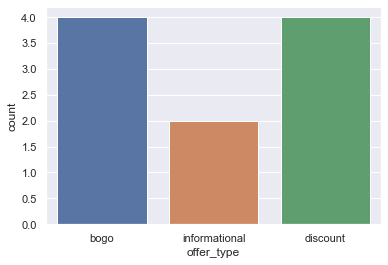

In [540]:
ax = sns.countplot(x="offer_type", data=portfolio)

In [541]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

PROFILE

In [542]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [543]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [544]:
profile.shape

(17000, 5)

In [545]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [546]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

some gender and some incomes null

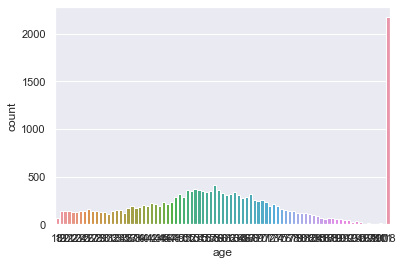

In [547]:
sns.set(style="darkgrid")
ax = sns.countplot(x="age", data=profile)


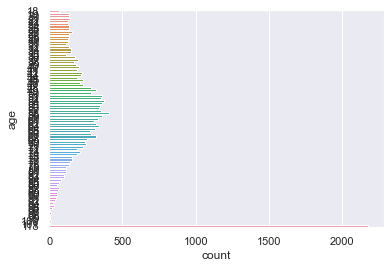

In [548]:
ax = sns.countplot(y="age", data=profile)

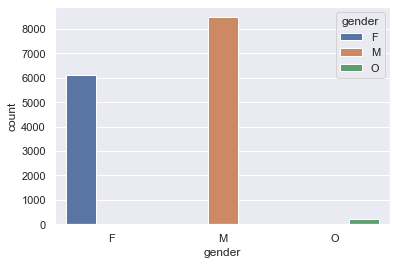

In [549]:
#gender counts
ax = sns.countplot(x="gender", hue="gender",  data=profile)

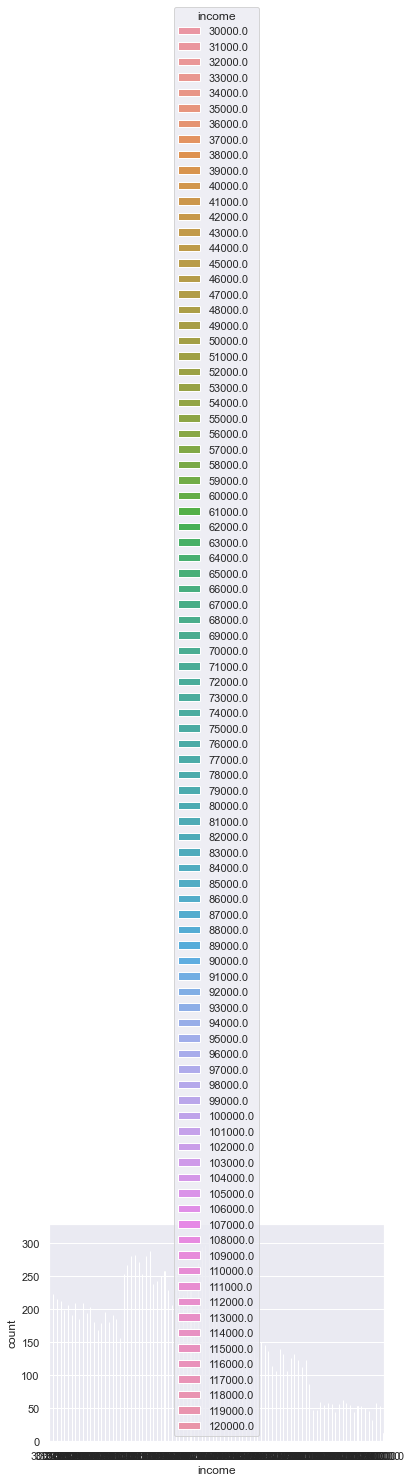

In [550]:
#income counts
ax = sns.countplot(x="income", hue="income",  data=profile)

/Users/gracelineberry/workspace/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


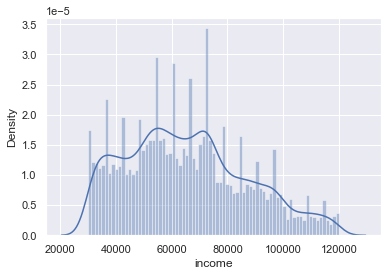

In [551]:
#income ranges
sns.distplot(profile['income'], bins=75);

/Users/gracelineberry/workspace/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


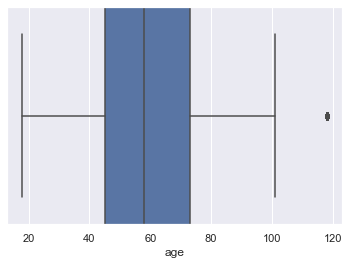

In [552]:
sns.boxplot(profile['age'], width=1.5);

There is an outlier at greater than 100 years old.  The description of the profile data indicates ages 118 are used to indicate data where the income and gender are unknown so this outlier makes sense but will need to be dealt with in the data wrangling phase

In [553]:
#how many 118's are there?
profile[profile['age']== 118].age.count()

2175

In [554]:
#check if all the 118's have a null gender
profile[((profile['age'] == 118) & (~profile['gender'].isnull()))]


,gender,age,id,became_member_on,income


In [555]:
#check if all the 118's have a null income
profile[((profile['age'] == 118) & (~profile['income'].isnull()))]


,gender,age,id,became_member_on,income


So all of the age 118 have a null income and null gender value.  These values can be removed in the data wrangling phase.

TRANSCRIPT

In [556]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [557]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [558]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [559]:
transcript.shape

(306534, 4)

In [560]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

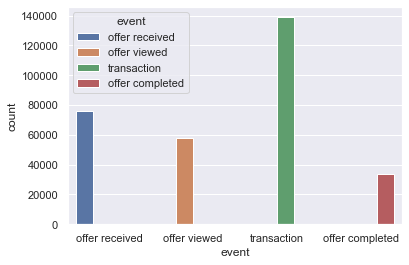

In [561]:
ax = sns.countplot(x="event", hue="event",  data=transcript)

/Users/gracelineberry/workspace/venv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


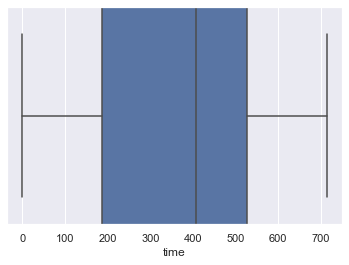

In [562]:
sns.boxplot(transcript['time'], width=1.5);

## Data Transformation

In [563]:

#use this to clean and format your column names:
def renameMyColumns(df):
  df.columns = (df.columns.str.strip().str.upper()
              .str.replace(' ', '_')
              .str.replace('(', '')
              .str.replace(')', ''))


PORTFOLIO

In [564]:
portfolio_clean = portfolio[['id', 'offer_type', 'reward', 'difficulty', 'duration', 'channels']].copy()

In [565]:
portfolio_clean.head()

,id,offer_type,reward,difficulty,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,"[web, email]"


In [566]:
portfolio_clean.rename(columns = {'id' :'offer_id'}, inplace='true')

In [567]:
portfolio_clean.head()

,offer_id,offer_type,reward,difficulty,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"[web, email, mobile, social]"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"[web, email, mobile]"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"[web, email, mobile]"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,"[web, email]"


In [568]:
portfolio_clean.isnull().sum()

offer_id      0
offer_type    0
reward        0
difficulty    0
duration      0
channels      0
dtype: int64

PROFILE

In [569]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [570]:
person_clean = profile[['id', 'gender', 'age', 'became_member_on', 'income']].copy()

In [571]:
person_clean.rename(columns = {'id' :'person_id'}, inplace='true')

replace missing age values with mean age

In [572]:
age_mean = person_clean['age'].mean()

In [573]:
person_clean.replace(118, age_mean , inplace=True)

replace the missing income values with mean income

In [574]:
income_mean = person_clean['income'].mean()

In [575]:
person_clean['income'] = person_clean['income'].fillna(person_clean['income'].mean())

replace missing gender value using gender mode

In [576]:
gender_mode = profile_clean['gender'].mode()

In [577]:
gender_mode

0    M
Name: gender, dtype: object

In [578]:
person_clean.isnull().sum()

person_id              0
gender              2175
age                    0
became_member_on       0
income                 0
dtype: int64

In [579]:
# there are still gender = 'O' rows but they have lots of good data, lets make them the mean
person_clean[person_clean['gender'] == 'O']

,person_id,gender,age,became_member_on,income
31,d1ede868e29245ea91818a903fec04c6,O,53.0,20170916,52000.0
273,d0be9ff460964c3398a33ad9b2829f3a,O,60.0,20180216,94000.0
383,0d0a9ca9281248a8a35806c9ae68f872,O,49.0,20171207,42000.0
513,01f46a5191424005af436cdf48a5da7c,O,63.0,20150920,89000.0
576,644ac06dc9b34a5bbd237a465cf47571,O,73.0,20180316,88000.0
...,...,...,...,...,...
16670,e8926849bbe24ce488d4f3fcd3b537e8,O,76.0,20180320,52000.0
16683,1f68e9b6850f49348235a281a47d9f15,O,49.0,20170607,56000.0
16731,a97208c5be42445d9949e82e0f70f622,O,51.0,20160707,55000.0
16741,994b6ef7a8ca46e3b379518399f6ec93,O,56.0,20180221,52000.0


In [580]:
person_clean['gender'] = person_clean['gender'].fillna(gender_mode[0])

In [581]:
person_clean.loc[person_clean["gender"] == "O", "gender"] = gender_mode[0]

In [582]:
# there are still gender = 'O' rows but they have lots of good data, lets make them the mean
person_clean[person_clean['gender'] == 'O']

,person_id,gender,age,became_member_on,income


In [583]:
person_clean.head()

,person_id,gender,age,became_member_on,income
0,68be06ca386d4c31939f3a4f0e3dd783,M,62.531412,20170212,65404.991568
1,0610b486422d4921ae7d2bf64640c50b,F,55.000000,20170715,112000.000000
2,38fe809add3b4fcf9315a9694bb96ff5,M,62.531412,20180712,65404.991568
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.000000,20170509,100000.000000
4,a03223e636434f42ac4c3df47e8bac43,M,62.531412,20170804,65404.991568


In [584]:
for income in person_clean:
    person_clean.loc[(person_clean.income < 10000) , 'income_level'] = 'Low'
    person_clean.loc[(person_clean.income >= 10000) & (person_clean.age <= 50000) , 'income_level'] = 'Lower_Middle'
    person_clean.loc[(person_clean.income >= 50000) & (person_clean.age <= 100000) , 'income_level'] = 'Upper_Middle'
    person_clean.loc[(person_clean.income >= 100000) , 'income_level'] = 'High'

In [585]:
person_clean.head()

,person_id,gender,age,became_member_on,income,income_level
0,68be06ca386d4c31939f3a4f0e3dd783,M,62.531412,20170212,65404.991568,Upper_Middle
1,0610b486422d4921ae7d2bf64640c50b,F,55.000000,20170715,112000.000000,High
2,38fe809add3b4fcf9315a9694bb96ff5,M,62.531412,20180712,65404.991568,Upper_Middle
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.000000,20170509,100000.000000,High
4,a03223e636434f42ac4c3df47e8bac43,M,62.531412,20170804,65404.991568,Upper_Middle


In [586]:
for income in person_clean:
    person_clean.loc[(person_clean.income < 10000) , 'income_level'] = 'Low'
    person_clean.loc[(person_clean.income >= 10000) & (person_clean.income <= 50000) , 'income_level'] = 'Lower_Middle'
    person_clean.loc[(person_clean.income >= 50000) & (person_clean.income <= 100000) , 'income_level'] = 'Upper_Middle'
    person_clean.loc[(person_clean.income >= 100000) , 'income_level'] = 'High'

In [587]:
for age in person_clean:
    person_clean.loc[(person_clean.age < 18) , 'age_group'] = 'Child'
    person_clean.loc[(person_clean.age >= 18) & (person_clean.age <= 30) , 'age_group'] = 'Young_Adult'
    person_clean.loc[(person_clean.age >= 30) & (person_clean.age <= 65) , 'age_group'] = 'Old_Adult'
    person_clean.loc[(person_clean.age >= 65) , 'age_group'] = 'Senior'

In [588]:
person_clean.head()

,person_id,gender,age,became_member_on,income,income_level,age_group
0,68be06ca386d4c31939f3a4f0e3dd783,M,62.531412,20170212,65404.991568,Upper_Middle,Old_Adult
1,0610b486422d4921ae7d2bf64640c50b,F,55.000000,20170715,112000.000000,High,Old_Adult
2,38fe809add3b4fcf9315a9694bb96ff5,M,62.531412,20180712,65404.991568,Upper_Middle,Old_Adult
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.000000,20170509,100000.000000,High,Senior
4,a03223e636434f42ac4c3df47e8bac43,M,62.531412,20170804,65404.991568,Upper_Middle,Old_Adult


In [589]:
person_clean.isnull().sum()

person_id           0
gender              0
age                 0
became_member_on    0
income              0
income_level        0
age_group           0
dtype: int64

TRANSCRIPT

In [590]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [591]:
transaction_clean = transcript[['person', 'event', 'value', 'time']].copy()

In [592]:
transaction_clean.rename(columns = {'person' :'person_id'}, inplace='true')

In [593]:
transaction_clean.head()

,person_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


change value column to offer id

In [594]:
transaction_clean['temp'] = transaction_clean['value'].apply(lambda x: x.get('offer id')

SyntaxError: incomplete input (3393447790.py, line 1)

In [ ]:
transaction_clean.temp.isnull().sum()

In [ ]:
transaction_clean[transaction_clean.temp.isna()]

In [ ]:
transaction_clean['amount'] = transaction_clean['value'].apply(lambda x: x.get('amount'))


In [ ]:
transaction_clean['offer_id_mispelled'] = transaction_clean['value'].apply(lambda x: x.get('offer_id'))


In [ ]:
transaction_clean.head()

In [ ]:
transaction_clean.head()

In [ ]:
for temp in transaction_clean:
    transaction_clean.loc[(~transaction_clean.temp.isnull()) , 'offer_id'] = transaction_clean['temp']
    transaction_clean.loc[(~transaction_clean.offer_id_mispelled.isnull()) , 'offer_id'] = transaction_clean['offer_id_mispelled']
 

In [ ]:
transaction_clean.amount.isna().sum()

In [ ]:
transaction_clean.offer_id.isna().sum()

In [ ]:
#check that offer_id or amount is filled out for every row.
transaction_clean[ transaction_clean.loc[ :,['offer_id','amount'] ].isnull().sum(axis=1) == 2]

In [ ]:
#drop temp columns
transaction_clean.drop(['offer_id_mispelled' , 'temp'] , axis=1, inplace=True)
    

In [ ]:
transaction_clean.head()

Merge all three data frames together to infer some details about the data and customer behaviors. 

In [ ]:
mega = pd.merge(portfolio_clean, transaction_clean, on='offer_id')
mega = pd.merge(mega, person_clean, on='person_id')

In [ ]:
mega.head()

In [ ]:
mega.gender.value_counts().plot(kind='pie', title='Gender Split', figsize=(5, 5), autopct='%1.1f%%')

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="event", hue="offer_type", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.legend(title='Starbucks Offers')
plt.ylabel('Total offers sent')
plt.xlabel('Offer Type')

Looks like buy one get one is the most viewed but the discount is the most completed

In [ ]:
mega.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="gender", hue="event", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Gender to event')
plt.legend(title='Event')
plt.ylabel('Counts of specific Events')
plt.xlabel('Gender')

Men and women are equally completing offers but women are more likely to complete an offer.  It takes sending several extra offers to men to get the same response rate as women.

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="income_level", hue="event", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Income to event')
plt.legend(title='Event')
plt.ylabel('Counts of specific Income levels')
plt.xlabel('Income level')

High Income levels are more likely to complete offers  

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="gender", hue="income", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of income to Gender')
plt.legend(title='Gender')
plt.ylabel('Counts of specific Income')
plt.xlabel('Gender')

In [ ]:
sns.boxplot(mega['income'], width=1.5);

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="gender", hue="income_level", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Income level to Gender')
plt.legend(title='Income Level')
plt.ylabel('Counts of specific Income Level')
plt.xlabel('Gender')

Looks like we still need to work on that gender pay gap

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="income_level", hue="age_group", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Income Level to Age Group')
plt.legend(title='Age Gropu')
plt.ylabel('Counts of specific Age Groups')
plt.xlabel('Income Level')

In [ ]:
So young adults dont have any money

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="gender", hue="age", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Age to Gender')
plt.legend(title='Age')
plt.ylabel('Counts of specific Ages')
plt.xlabel('Gender')

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x="gender", hue="age_group", data=mega)
sns.set(style="darkgrid")
plt.title('Distribution of Age to Gender')
plt.legend(title='Age')
plt.ylabel('Counts of specific Age Groups')
plt.xlabel('Gender')

This one might be skewed where we added 62.5 as the median age and Men as the gender when those values were not present. 

# Prep data for training

In [778]:
mega.head()
preTrain = mega.copy()

In [779]:
#change all the event types to numbers
preTrain['event'] = preTrain['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    

In [780]:
preTrain.head()

,offer_id,offer_type,reward,difficulty,duration,channels,person_id,event,value,time,amount,gender,age,became_member_on,income,income_level,age_group
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]",4b0da7e80e5945209a1fdddfe813dbe0,1,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,NaN,M,64.0,20170909,100000.0,High,Old_Adult
1,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]",4b0da7e80e5945209a1fdddfe813dbe0,2,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},102,NaN,M,64.0,20170909,100000.0,High,Old_Adult
2,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]",4b0da7e80e5945209a1fdddfe813dbe0,1,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},504,NaN,M,64.0,20170909,100000.0,High,Old_Adult
3,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]",4b0da7e80e5945209a1fdddfe813dbe0,2,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},510,NaN,M,64.0,20170909,100000.0,High,Old_Adult
4,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"[email, mobile, social]",4b0da7e80e5945209a1fdddfe813dbe0,3,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,510,NaN,M,64.0,20170909,100000.0,High,Old_Adult


In [781]:
#change all the age_groups to numbers
preTrain['age_group'] = preTrain['age_group'].map({'Child':1, 'Young_Adult':2, 'Old_Adult':3, 'Senior':4})
 

In [782]:
#change all the income levels to numbers
preTrain['income_level'] = preTrain['income_level'].map({'Low':1, 'Lower_Middle':2, 'Upper_Middle':3, 'High':4})
 

In [783]:
#change all the offer types to numbers
preTrain['offer_type'] = preTrain['offer_type'].map({'bogo':1, 'informational':2, 'discount':3})
 

In [784]:
#change all the gender types to numbers
preTrain['gender'] = preTrain['gender'].map({'M':1, 'F':2, 'O':3})
 

In [785]:
#convert income to a number between -1 and 1
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
preTrain['income'] = std.fit_transform(preTrain['gender'].values.reshape(-1, 1))

In [786]:
preTrain['offer_type'] = std.fit_transform(preTrain['offer_type'].values.reshape(-1, 1))

In [787]:
preTrain['reward'] = std.fit_transform(preTrain['reward'].values.reshape(-1, 1))

In [788]:
preTrain['difficulty'] = std.fit_transform(preTrain['difficulty'].values.reshape(-1, 1))

In [789]:
preTrain['income_level'] = std.fit_transform(preTrain['income_level'].values.reshape(-1, 1))

In [790]:
preTrain['age_group'] = std.fit_transform(preTrain['age_group'].values.reshape(-1, 1))

In [791]:
#preTrain['event'] = std.fit_transform(preTrain['event'].values.reshape(-1, 1))

In [792]:
#drop unused columns

In [793]:
preTrain.drop('person_id',axis=1, inplace=True)  
preTrain.drop('value',axis=1, inplace=True)  
preTrain.drop('amount',axis=1, inplace=True)  
preTrain.drop('age',axis=1, inplace=True)  
preTrain.drop('became_member_on',axis=1, inplace=True)  
preTrain.drop('offer_id',axis=1, inplace=True)
preTrain.drop('channels',axis=1, inplace=True)
preTrain.drop('time',axis=1, inplace=True)
preTrain.drop('duration',axis=1, inplace=True)

In [794]:
preTrain.head()

,offer_type,reward,difficulty,event,gender,income,income_level,age_group
0,-1.077111,1.654169,0.425754,1,1,-0.785888,2.258007,-0.302649
1,-1.077111,1.654169,0.425754,2,1,-0.785888,2.258007,-0.302649
2,-1.077111,1.654169,0.425754,1,1,-0.785888,2.258007,-0.302649
3,-1.077111,1.654169,0.425754,2,1,-0.785888,2.258007,-0.302649
4,-1.077111,1.654169,0.425754,3,1,-0.785888,2.258007,-0.302649


In [795]:
label = preTrain['event']

In [796]:
preTrain = preTrain.drop('event', axis=1)

Split data into training and test

In [797]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, accuracy_score
 

In [798]:
X_train, X_test, y_train, y_test = train_test_split(preTrain, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 100548 rows
Testing set: 67033 rows


In [799]:
#reset indexes
X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)
X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)
X_test

,offer_type,reward,difficulty,gender,income,income_level,age_group
0,-1.077111,1.654169,0.425754,1,-0.785888,0.275957,-2.078869
1,0.011163,-1.310244,-1.554865,1,-0.785888,2.258007,-0.302649
2,0.011163,-1.310244,-1.554865,3,3.082005,0.275957,-0.302649
3,1.099437,-0.717361,0.425754,1,-0.785888,-1.706093,-0.302649
4,0.011163,-1.310244,-1.554865,2,1.148059,2.258007,1.473571
...,...,...,...,...,...,...,...
67028,-1.077111,0.171962,-0.564556,1,-0.785888,0.275957,-0.302649
67029,1.099437,-0.717361,0.425754,1,-0.785888,0.275957,-0.302649
67030,-1.077111,1.654169,0.425754,2,1.148059,2.258007,1.473571
67031,-1.077111,0.171962,-0.564556,2,1.148059,0.275957,-0.302649


Train the Model!  K Neighbors 

In [800]:
neighbor = KNeighborsClassifier(n_neighbors = 5)

In [801]:
training_prediction =  (neighbor.fit(X_train, y_train)).predict(X_train)

In [802]:
test_prediction = (neighbor.fit(X_train, y_train)).predict(X_test)

In [803]:
training_f1 =  accuracy_score(y_train, training_prediction) * 100 

In [804]:
test_f1 = fbeta_score(y_test, test_prediction, beta = 0.5, average='micro' ) * 100

In [805]:
print("Benchmark Training F1 Score:{}, Testing F1 Score:{}", training_f1, test_f1)

Benchmark Training F1 Score:{}, Testing F1 Score:{} 42.2713529856387 42.08076618978712


Random Forest Classifier

In [806]:
forest = RandomForestClassifier(random_state = 10)

In [807]:
forest_training_prediction = (forest.fit(X_train, y_train)).predict(X_train)

In [808]:
forest_test_prediction = (forest.fit(X_train, y_train)).predict(X_test)

In [809]:
forest_training_f1 = accuracy_score(y_train, forest_training_prediction) * 100 

In [810]:
forest_test_f1 = fbeta_score(y_test, forest_test_prediction, beta = 0.5, average='micro' ) * 100

In [811]:
print("Random Forests Training F1 Score:{}, Testing F1 Score:{}", forest_training_f1, forest_test_f1)

Random Forests Training F1 Score:{}, Testing F1 Score:{} 45.65182798265505 45.21504333686393


Balanced Random Forest Classifier

In [812]:
B_forest = RandomForestClassifier(random_state = 10, class_weight="balanced")

In [813]:
B_forest_training_prediction = (B_forest.fit(X_train, y_train)).predict(X_train)

In [814]:
B_forest_test_prediction = (B_forest.fit(X_train, y_train)).predict(X_test)

In [815]:
B_forest_training_f1 = accuracy_score(y_train, B_forest_training_prediction) * 100 

In [816]:
B_forest_test_f1 = fbeta_score(y_test, B_forest_test_prediction, beta = 0.5, average='micro' ) * 100

In [817]:
print("Balanced Random Forests Training F1 Score:{}, Testing F1 Score:{}", B_forest_training_f1, B_forest_test_f1)

Balanced Random Forests Training F1 Score:{}, Testing F1 Score:{} 36.31797748339102 35.94349051959483


In [818]:
X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

In [819]:
X_test

,offer_type,reward,difficulty,gender,income,income_level,age_group
0,-1.077111,1.654169,0.425754,1,-0.785888,0.275957,-2.078869
1,0.011163,-1.310244,-1.554865,1,-0.785888,2.258007,-0.302649
2,0.011163,-1.310244,-1.554865,3,3.082005,0.275957,-0.302649
3,1.099437,-0.717361,0.425754,1,-0.785888,-1.706093,-0.302649
4,0.011163,-1.310244,-1.554865,2,1.148059,2.258007,1.473571
...,...,...,...,...,...,...,...
67028,-1.077111,0.171962,-0.564556,1,-0.785888,0.275957,-0.302649
67029,1.099437,-0.717361,0.425754,1,-0.785888,0.275957,-0.302649
67030,-1.077111,1.654169,0.425754,2,1.148059,2.258007,1.473571
67031,-1.077111,0.171962,-0.564556,2,1.148059,0.275957,-0.302649


Decision Tree Classifier

In [820]:
dtc = DecisionTreeClassifier(random_state = 10)

In [821]:
dtc_training_prediction = (dtc.fit(X_train, y_train)).predict(X_train)

In [822]:
dtc_test_prediction = (dtc.fit(X_train, y_train)).predict(X_test)

In [823]:
dtc_training_f1 = accuracy_score(y_train, dtc_training_prediction) * 100 

In [824]:
dtc_test_f1 = fbeta_score(y_test, dtc_test_prediction, beta = 0.5, average='micro' ) * 100

In [825]:
print("Decision Tree Classifier Training F1 Score:{}, Testing F1 Score:{}", dtc_training_f1, dtc_test_f1)

Decision Tree Classifier Training F1 Score:{}, Testing F1 Score:{} 45.65182798265505 45.21504333686393


# Conclusions

In [826]:
f1Scores = {'Algorithm Type': ['K Neighbors Classifier', 'Random Forest Classifier', 'Balanced Random Forest Classifier', 'Decision Tree Classifier'], 
          'Training F1 score ':[training_f1, forest_training_f1, B_forest_training_f1, dtc_training_f1], 
          'Testing F1 score': [test_f1, forest_test_f1, B_forest_test_f1, dtc_test_f1] }
          
compare_df = pd.DataFrame(f1Scores)
compare_df.head()

,Algorithm Type,Training F1 score,Testing F1 score
0,K Neighbors Classifier,42.271353,42.080766
1,Random Forest Classifier,45.651828,45.215043
2,Balanced Random Forest Classifier,36.317977,35.943491
3,Decision Tree Classifier,45.651828,45.215043


From the comparison table above we can see that the K Nearest Nieghbor benchmark is only beaten by the Random Forest and Decision Tree Classifier algorithms.  These test and F1 scores are similar and are within range of eachother.  This means that Starbucks should use the Decision Tree Classifer to make decisions about which type of offers to send.  An analysis of the data graphs in the previous section suggest that high income women are more likely to complete an offer so focusing offers sent to them will generate the best completion rate. 

# Next Steps

In the future we could add a web endpoint and wrap that with some html code to take in a few input items like Gender, Age, Income and predict the likelyhood of an offer event being completed.  This would use the Decision Tree Classifier and would be able to accurately predict a users behavior given those entered customer data points. 